In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker

import datetime
import time
import csv
import os
import pandas as pd
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ConstantModel, PseudoVoigtModel


# data-handling
from glob import glob

# pyFAI
from pyFAI.multi_geometry import MultiGeometry 
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.goniometer import GeometryTranslation
from pyFAI.goniometer import GoniometerRefinement
from pyFAI.goniometer import Goniometer
import pyFAI
#from pyFAI.multi_geometry import GeometryTranslation, GoniometerRefinement, Goniometer, Multigeometry
from pyFAI.calibrant import get_calibrant
from pyFAI.gui import jupyter
import fabio

In [18]:
#importing information and data from experiment

#diffraction data
#calibration
calibration_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190219\\calibration\\calibration files"
calibration_function = os.path.join(calibration_folder, "Lab6calib.json")

#experiment
filenames = ["cell2"] #"cell2", 
filename = 'cell2'
expt_folder =  "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\cell2"
name_raw_folder = expt_folder + "\\images"
#expt_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\cell2"


#images_folder = expt_folder + name_raw_folder
saved_1d_data = expt_folder + "\\1D_Data"
saved_figures = expt_folder + "\\saved_figures"
saved_fit_figures = saved_figures + "\\saved_fits"

csv_format = filename + "_scan"
sample_csv = filename + "_scan1.csv"
image_format = "b_toney_" + filename + "_scan"

#make folders to put 1D Q vs intensity csvs and figures if they aren't there yet
if not os.path.exists(saved_1d_data):
    os.makedirs(saved_1d_data)

if not os.path.exists(saved_figures):
    os.makedirs(saved_figures)
    
if not os.path.exists(saved_fit_figures):
    os.makedirs(saved_fit_figures)    

#detector params for read raw
w = 487
h = 195
npt = 500 #number of points in integration
scanlist = filename
npt = 400

#echem 
echem_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\echem"
#echem_folder = "C:\\Users\\Natalie\\OneDrive - SLAC National Accelerator Laboratory\\Documents\\Research - Toney\\Data\\processing & codes\\current code"
date_formatec = '%m/%d/%Y %H:%M:%S.%f'
current_dens_sigma = 0.01

#spec inputs
date_format_fraction = '%Y-%m-%d %H:%M:%S.%f'
date_format = '%Y-%m-%d %H:%M:%S'
monitor_threshold = 0.185

In [16]:
##creates list of scans and times from spec file
#os.chdir(expt_folder)
    
def cutdata(q, intensity,low, high):
    x = q[(q>low)&(q<high)]
    y = intensity[(q>low)&(q<high)]
    #actually cut data that is outside of good q range 
    return x,y

def separate_scans(specfile, monitor_threshold):
    scans_Li = []
    scans_LiF = []
    times_Li = []
    times_LiF = []
    scans_full = []
    times_full = []
    with open(specfile, 'r') as fout:
        specfile = fout.readlines()
    for i, line in enumerate(specfile):
        if "#E" in specfile[i]:
            split_epochline = (line.split())
            epoch_start = split_epochline[1]
            print('Epoch=', epoch_start)
        if "#S" in specfile[i]:
            try: 
                split_scanline = (specfile[i].split())
                scan_no = int(split_scanline[1])
                #print(scan_no)
                scan_type = split_scanline[2]
                #print(scan_type)
                scan_start =split_scanline[4]
                if scan_type == "ascan":    
                    split_angle_line = (specfile[i+8].split())
                    angle = split_angle_line[1]
                    if scan_start == "-1.7":
                        #check that first img in each scan at least had enough counts
                        indv_scan_line = specfile[i+22].split()
                        monitor_first_scan = indv_scan_line[-2]
                        #print(monitor_first_scan)
                        if float(monitor_first_scan) >= monitor_threshold:
                            
                            
                            if float(angle) == 22.5:
                                scans_LiF.append(scan_no)
                                split_timeline = (specfile[i+23].split())
                                times_LiF.append(float(split_timeline[4]))
        
                            if float(angle) == 19.8:
                                scans_Li.append(scan_no)
                                split_timeline = (specfile[i+23].split())
                                #print(split_timeline)
                                times_Li.append(float(split_timeline[4]))
                        else:
                            print("low monitor with scan#", split_scanline[1])
                if scan_type == "a2scan":
                    scans_full.append(scan_no)
                    split_timeline = (specfile[i+22].split())
                    times_full.append(float(split_timeline[5]))
            except:
                print("problem with scan#", split_scanline[1])
    return scans_Li, scans_LiF, scans_full, times_Li, times_LiF, times_full, epoch_start

def separate_echem(echem_filename, current_dens_sigma):
    
    #get echem data
    os.chdir(echem_folder)
    echem_filename = glob("*" + filename + "*.txt")
    echem_file = echem_filename[0]
    #print('filename', echem_file)
    ec_data = pd.read_csv(echem_file, delimiter='\t')
    #print('columns', ec_data.columns)
    
    #change text to value for columns that have numbers in them
    numeric_cols = ['Ns', 'Ewe/V', '<I>/mA', 'Capacity/mA.h', 'Q discharge/mA.h', 'Q charge/mA.h']
    for col in numeric_cols:
        ec_data[col] = pd.to_numeric(ec_data[col])
    
    #find difference in current from previous value - if changes too much, adds 1 to that column: 
    #used to create groups for difference e chem sections
    delta_max = current_dens_sigma
    ec_data['differences'] = ec_data['<I>/mA'].diff()\
            .abs()\
            .gt(delta_max)\
            .cumsum() #needs to be absolute difference
    

    
    
       
    #convert absolute time to time delta, put in additional column in data from
    time_abs  = ec_data['time/s']
    ec_data['time_translated'] = (pd.to_datetime(time_abs, format=date_formatec))
    start_time = ec_data['time_translated'].iloc[0]
    print(start_time)
    time_delta = pd.to_timedelta(ec_data['time_translated'] - start_time) / np.timedelta64(1, 's')   
    ec_data['time_delta'] = time_delta
    potential = ec_data['Ewe/V']
    current   = ec_data['<I>/mA']
    
    #create data frame with start and end times for the different echem sections
    split = ec_data.groupby(["differences"])
    
    
    stage = []
    starts = []
    ends = []
    capacities = []
    for name, group in split:
        print('name', name)
        print('start time', group['time_translated'].iloc[0])
        print('end time',   group['time_translated'].iloc[-1])
        stage.append(name)
        starts.append(group['time_translated'].iloc[0])
        ends.append(group['time_translated'].iloc[-1])
        capacities.append(group['Capacity/mA.h'].iloc[-1])
    time_periods = pd.DataFrame({'Ns':stage,
                                 'start time':starts,
                                 'end time':ends,
                                 'capacity': capacities
                                })
    
    os.chdir(echem_folder)
    time_periods.to_pickle("./" + filename + "echem-cycle-times.pkl")
    #make some plots of the echem and save
    plt.figure(1)
    plt.plot(time_delta/3600, potential)
    plt.xlabel("Time /hour")
    plt.ylabel("Potential /V (vs. Ag/AgCl)")
    plt.ylim(-3.5, 3.5)
    plt.title(filename)
    plt.gcf()
    plt.tight_layout()
    os.chdir(saved_figures)
    plt.savefig('potential vs time2')
    plt.show()
    
    plt.figure(2)
    plt.plot(time_delta/3600, current)
    plt.xlabel("Time /hour")
    plt.ylabel("Current /mA")
    plt.title(filename)
    plt.show()
    plt.gcf()
    plt.tight_layout()
    os.chdir(saved_figures)
    plt.savefig('current vs time2')
    return ec_data, time_periods


def gaussfit(x, y, guess, limits):
    gauss_mod  = GaussianModel(prefix='gauss_')
    line_mod = LinearModel(prefix='line_')
    const_mod = ConstantModel(prefix='const_')
    
    #print(np.shape(guess1))
    gauss_mod.set_param_hint('amplitude',value=guess[1])#, min = 0)#, max = 0.8e8)#, max=(guess1[1]+0.1e7))#, max=guess1[1]+1e7, min=guess1[1]-1e7)#, max=3e7)#, min=0.0, max = .3)#, max=9) #pos 1 trial 1 max 8/9
    gauss_mod.set_param_hint('sigma',    value=0.0040)#, min = 0.001, max = 0.0055)#, min=0.004, max=.02)#min=0.0015, max=0.0045?
    gauss_mod.set_param_hint('center',   value=guess[2], min = 2.529, max = 2.535)#, min = 2.53, max = 2.545)#pos 1 trial 1 min = 2.5317, max = 2.5321
    #2.53344958949
    gauss_mod.set_param_hint('height',value = guess[4], min = 0)#, max=0.32e10)#, max=guess1[4]+1e8, min=guess1[4]-1e8) #id not have
    line_mod.set_param_hint('intercept', value = y[1])
    
    pars = gauss_mod.make_params()
    pars += line_mod.make_params() 
    mod = gauss_mod  + line_mod

    out = mod.fit(y, pars, x=x)
    
    #print(fit_report())
    amplitude = out.params.valuesdict()['gauss_amplitude']
    width = (out.params.valuesdict()['gauss_sigma']      )   
    center = (out.params.valuesdict()['gauss_center']   ) 
    height = (out.params.valuesdict()['gauss_height']   )
    gfit = (out.chisqr)
    return amplitude, width, center,height,gfit, out


def pv_fit(x, y, guess, limits):
    pv_mod  = PseudoVoigtModel(prefix='pv_')
    line_mod = LinearModel(prefix='line_')
    

    pv_mod.set_param_hint('amplitude',value=1e6)#guess[1]
    pv_mod.set_param_hint('sigma', value=0.004, max = 0.006)#
    pv_mod.set_param_hint('center',  value = 2.53, min = 2.529, max = 2.535)#
    pv_mod.set_param_hint('fraction', value = 0.5, min = 0, max = 1)#
    line_mod.set_param_hint('intercept', value = y[1])
    pars = pv_mod.make_params()
    pars += line_mod.make_params() 
    mod = pv_mod  + line_mod
    out = mod.fit(y, pars, x=x)
    #print(fit_report())
    
    amplitude = out.params.valuesdict()['pv_amplitude']
    width =    (out.params.valuesdict()['pv_fwhm']      )   
    center =   (out.params.valuesdict()['pv_center']   ) 
    fraction =   (out.params.valuesdict()['pv_fraction']   ) #### NOT HEIGHT
    background = (out.params.valuesdict()['line_intercept']   )
    slope = (out.params.valuesdict()['line_slope']   )
    gfit = (out.chisqr)
    return amplitude, width, center, fraction, gfit, background, slope, out #outsputs fraction rather than height here



def sum_scans(scan_no, no_scans_to_sum):
    os.chdir(saved_1d_data)
    #print(os.listdir())
    csv1 = glob(str(scan_no) + ".csv")
    column_names = ['intensity','q']
    
    try:
        data_scan = pd.read_csv(csv1[0], usecols=[0,1], names = column_names)
        #print(data_scan)
        intensity = (data_scan['intensity'])
        q = (data_scan['q'])
        #plt.plot(q, intensity)
        #print((no_scans_to_sum))
        for i in range(1,no_scans_to_sum, 1):
            
            
            csv2 = glob(str(scan_no+i) + ".csv")
            #print(csv2)
            data_scan2 = pd.read_csv(csv2[0], usecols=[0,1], names = column_names)
            intensity2 = (data_scan2['intensity'])
            
            intensity = intensity + intensity2
    
    except:
        print('error summing scans')
    intensity = intensity/no_scans_to_sum
    #plt.plot(q, intensity)
    #plt.show()
    return q, intensity

def show_and_save_fits(all_fits, saved_fit_figures):
    os.chdir(saved_fit_figures)
    fig1 = plt.gcf()
    plt.figure(3)
    plt.plot(all_fits[:, 0, 0])
    #plt.ylim(2.51, 2.55)
    plt.title('width of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time')
    plt.savefig(specfile + 'peak width vs scan no');
    fig1 = plt.gcf()
    plt.figure(4)
    plt.plot(all_fits[:, 0, 1])
    #plt.ylim(2.51, 2.55)
    plt.title('integ intens of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
    plt.savefig(specfile +'intensity vs scan no');
    fig1 = plt.gcf()
    plt.figure(5)
    plt.plot(all_fits[:, 0, 2])
    plt.ylim(2.51, 2.55)
    plt.title('center of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
    plt.savefig(specfile +'peak center vs scan no');
    fig1 = plt.gcf()
    plt.figure(6)
    plt.plot(all_fits[:, 0, 3])
    #plt.ylim(2.51, 2.55)
    plt.title('good fit of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
    plt.savefig(specfile +'fit vs scan no');
    fig1 = plt.gcf()
    plt.figure(7)
    plt.plot(all_fits[:, 0, 4])
    #plt.ylim(2.51, 2.55)
    plt.title('height of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
    plt.savefig(specfile +'height vs scan no');

In [5]:
os.chdir(saved_1d_data)
df = pd.DataFrame.from_csv('total_experiment_df.csv')
intensities = df
plt.figure(0)
plt.imshow((intensities), interpolation = 'none', aspect = 'auto')#, extent=(min(q), max(q), max(scans_Li), min(scans_Li)))
plt.show()
# vmin = 1000000000, vmax = 20000000000

AttributeError: type object 'DataFrame' has no attribute 'from_csv'

2019-03-30 09:45:39.000200
name 0
start time 2019-03-30 09:45:39.000200
end time 2019-03-30 09:54:13.421200
name 1
start time 2019-03-30 09:54:13.421600
end time 2019-03-30 10:54:23.106300
name 2
start time 2019-03-30 10:54:23.154500
end time 2019-03-30 15:54:23.106700
name 3
start time 2019-03-30 15:54:23.107900
end time 2019-03-30 16:28:34.857500
name 4
start time 2019-03-30 16:28:34.905900
end time 2019-03-30 21:28:34.857800


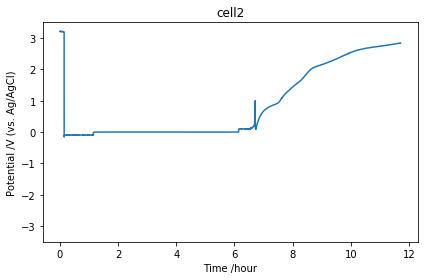

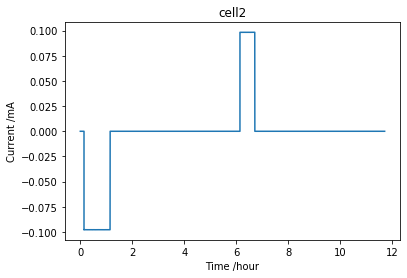

(5, 4)
(10409, 13)
   Ns                 start time                   end time      capacity
0   0 2019-03-30 09:45:39.000200 2019-03-30 09:54:13.421200  4.800380e-09
1   1 2019-03-30 09:54:13.421600 2019-03-30 10:54:23.106300  9.800000e-02
2   2 2019-03-30 10:54:23.154500 2019-03-30 15:54:23.106700  4.948964e-09
3   3 2019-03-30 15:54:23.107900 2019-03-30 16:28:34.857500  5.599948e-02
4   4 2019-03-30 16:28:34.905900 2019-03-30 21:28:34.857800  5.599948e-02


<Figure size 432x288 with 0 Axes>

In [19]:
ec_data, time_periods = separate_echem(filename, current_dens_sigma)
print(np.shape(time_periods))
print(np.shape(ec_data))
print(time_periods)

In [7]:
qs = [2.53]
windows = np.array([
                    [2.40, 2.65],
                    ])

npeaks = len(qs)
print("No. peaks to fit:", npeaks)



No. peaks to fit: 1


In [8]:
print(saved_1d_data)
#help(os.chdir)

H:\Data\ProjectsandData\LiXRD\open cell\cone cell\20190329\cell2\1D_Data


In [9]:
os.chdir(expt_folder)
scans_Li, scans_LiF, scans_full, times_Li, times_LiF, times_full, epoch_start = separate_scans(filename, monitor_threshold)
print("scans_Li", scans_Li[0:10])
times_Li = np.array(times_Li)
times_Li = times_Li.astype(int)


print("times_Li", times_Li[0:10])
epoch_times_Li = (times_Li) + int(epoch_start) - 25200 #really not sure on what time zones these are in

print("epoch_times_Li",epoch_times_Li[0:10])
scan_times_Li = pd.to_datetime(epoch_times_Li, unit='s')
print(scan_times_Li[0:10])
#print(ec_data['time_translated'].iloc[0:10])

nfiles = len(scans_Li)
npeaks = len(qs)
print(nfiles)
outs = []
data = []

Epoch= 1553962802
scans_Li [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
times_Li [1406 1436 1467 1497 1527 1558 1588 1618 1649 1679]
epoch_times_Li [1553939008 1553939038 1553939069 1553939099 1553939129 1553939160
 1553939190 1553939220 1553939251 1553939281]
DatetimeIndex(['2019-03-30 09:43:28', '2019-03-30 09:43:58',
               '2019-03-30 09:44:29', '2019-03-30 09:44:59',
               '2019-03-30 09:45:29', '2019-03-30 09:46:00',
               '2019-03-30 09:46:30', '2019-03-30 09:47:00',
               '2019-03-30 09:47:31', '2019-03-30 09:48:01'],
              dtype='datetime64[ns]', freq=None)
1382


sorting scans in stage 0 i= 0
making background from stage 0
[11, 13, 15, 17, 19, 21, 23, 25, 27]


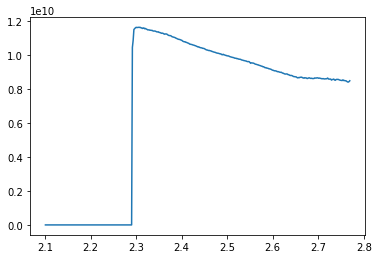

sorting scans in stage 1 i= 1
113
fitting scans in stage 1 None
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
sorting scans in stage 2 i= 2
559
fitting scans in stage 2 None
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483


"time_periods['Number of scans'] = no_scans_in_each_stage\nprint(time_periods['Number of scans'])"

In [10]:
no_scans_in_each_stage = []

#adjust fitting limits
limits = {'stage0': [], 'stage1': [], 'stage2':[],'stage3':[], 'stage4': []}
limits = pd.DataFrame(data=limits)

for i, stage in enumerate(time_periods.iloc[:,0]): # for each section of the electrochemical data (ie OCV - CC - OCV)
    os.chdir(expt_folder)
    print("sorting scans in stage", stage, 'i=', i)
    #print("start", time_periods.iloc[i,1], "end", time_periods.iloc[i,2])
    start = time_periods.iloc[i,1]
    end = time_periods.iloc[i,2]
    
    scans_in_stage = []
    scantimes_in_stage = []
    for n, scan_no in (enumerate((scans_Li))):
        #check which scans are in this stage
        scan_time  = scan_times_Li[n]
        if scan_time > start and scan_time < end:
            #print(scan_no)
            scans_in_stage.append(scan_no)
            scantimes_in_stage.append(scan_time)
            
    no_scans_in_each_stage.append(len(scans_in_stage))
    
    
    if i == 0:
        print("making background from stage", stage)
        print(scans_in_stage)
        scan = scans_in_stage[0]
        q, background = sum_scans(scan, len(scans_in_stage))
        #print(background)
        plt.figure(scan)
        plt.gcf()
        plt.plot(q, background)
        
        save = os.path.join(saved_fit_figures, str(scan) + '-background.jpg')
        plt.savefig(save)
        plt.show()

    if i >= 1:
        outs = []
        all_fits = np.zeros((len(scans_in_stage), npeaks, 8))
        print("fitting scans in stage", stage, print(len(scans_in_stage)))
        for n, scan in enumerate(scans_in_stage):
            #print(bg_sub_intensity)
            for j, peak in enumerate(qs):
            
            
                print(scan)
                if n == 0:
                    guess = (0.0, 0.0, 2.53, 0, 0.0)
                if n >= 1:
                    guess = all_fits[n-1, j, :]
                    #print(guess)
                    
                q, intensity = sum_scans(scan, 2)
                #print(intensity)
                #plt.figure(2)
                #plt.plot(q, intensity)
                #plt.show()
                bg_sub_intensity = intensity - background
                

                x,y = cutdata(q, bg_sub_intensity.values, windows[j,0], windows[j,1])
                #print(guess)
                limits = []
                amplitude, width, center, fraction, gfit, background_l, slope, out = pv_fit(x, y, guess, limits) 
                outs.append(out)
                
                
                fig = plt.figure(scan)
                plt.gcf()
                plt.plot(x, outs[n].best_fit)
                outs[n].plot_fit()
                plt.ylim(-7e8, 2e9)
                savepath = os.path.join(saved_fit_figures, str(scan) + '-fit.jpg')
                plt.savefig(savepath)
                #plt.show()
                plt.close(scan)
              
                all_fits[n, j, 0] = amplitude
                all_fits[n, j, 1] = width
                all_fits[n, j, 2] = center
                all_fits[n, j, 3] = fraction
                all_fits[n, j, 4] = background_l
                all_fits[n, j, 5] = slope
                all_fits[n, j, 6] = gfit
                all_fits[n, j, 7] = scan
        os.chdir(saved_figures)
        stage = str(stage)
        fig1 = plt.gcf()
        plt.figure(0)
        plt.plot(all_fits[:, 0, 0])
        #plt.ylim(2.51, 2.55)
        plt.title('Int. Intes. of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time')
        plt.savefig(filename +" " + stage + ' Int Intes width vs scan no.jpg');
        fig1 = plt.gcf()
        plt.close(0)
        
        plt.figure(1)
        plt.plot(all_fits[:, 0, 1])
        #plt.ylim(2.51, 2.55)
        plt.title('Width of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +" " + stage + ' peak width vs scan no.jpg');
        fig1 = plt.gcf()
        plt.close(1)
        
        plt.figure(2)
        plt.plot(all_fits[:, 0, 2])
        plt.ylim(2.51, 2.55)
        plt.title('center of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +'peak center vs scan no.jpg');
        fig1 = plt.gcf()
        plt.close(2)
        
        plt.figure(3)
        plt.plot(all_fits[:, 0, 3])
        plt.ylim(-2,2)
        plt.title('p-v fraction of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +" " + stage + ' fraction vs scan no.jpg');
        fig1 = plt.gcf()
        plt.close(3)
        
        plt.figure(4)
        plt.plot(all_fits[:, 0, 4])
        #plt.ylim(2.51, 2.55)
        plt.title('Background intercept of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +" " + stage + ' bg intercept vs scan no.jpg');
        plt.close(4)
        
        plt.figure(5)
        plt.plot(all_fits[:, 0, 5])
        #plt.ylim(2.51, 2.55)
        plt.title('linear slope of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +" " + stage + ' bg slope vs scan no.jpg');
        plt.close(5)
        
        plt.figure(6)
        plt.plot(all_fits[:, 0, 6])
        #plt.ylim(2.51, 2.55)
        plt.title('Fit of Li (110) peak at theta=3$\mathregular{^o}$ vs. Time');
        plt.savefig(filename +" " + stage + ' fit vs scan no.jpg');
        plt.close(6)
        
        all_fits_df = pd.DataFrame(all_fits[:,0,:], columns=['amplitude','width','center', 'fraction', 'background_l', 'slope', 'fit', 'scan_no'], index=scantimes_in_stage)
        savename = str(stage) +'all_fits_df.csv'
        savepath = os.path.join(saved_fit_figures, savename)
        all_fits_df.to_csv(savepath)
        
                
                
    
    
"""time_periods['Number of scans'] = no_scans_in_each_stage
print(time_periods['Number of scans'])"""

In [11]:
os.chdir(saved_1d_data)

df = pd.DataFrame({'scan_times': scan_times_Li,
                  'scans': scans_Li})
savename = 'scans.csv'
df.to_csv(savename)

savename = 'echem_time_periods.csv'
time_periods.to_csv(savename)

In [ ]:
diff = np.concatenate([[0.0], fit_tot[2:, 0, 1] - fit_tot[:-2, 0, 1],[0.0]])
plt.plot(np.abs(diff))
plt.figure()
diff_sub = diff[np.abs(diff) < 4.0E5]
plt.plot(diff_sub)
plt.figure()
fit_tot_sub = np.where(np.abs(diff) < 2.0E6, fit_tot[:, 0, 1], np.nan)
plt.plot(fit_tot_sub)

In [ ]:
#get echem data
os.chdir(echem_folder)
echem_filename = glob("*" + filename + "*.txt")
echem_file = echem_filename[0]
print(echem_file)


ec_data = pd.read_csv(echem_file, delimiter='\t')
print(ec_data.columns)
time_abs  = ec_data['time/s']
potential = ec_data['Ewe/V']
current   = ec_data['<I>/mA']


start_time = time_abs[0]
last = len(time_abs)-1
end_time = time_abs[last]

#convert the strings that represent the time to a time that python understands and then to a time delta
time_translated = (pd.to_datetime(time_abs, format=date_formatec))

#find the start and end times
start_time = time_translated[0]
last =   len(time_translated)-1
end_time =   time_translated[last]

#convert time into time since beginning of expt
time_delta = pd.to_timedelta(time_translated - start_time) / np.timedelta64(1, 's')
plt.figure(1)
plt.plot(time_delta/3600, potential)
plt.xlabel("Time /hour")
plt.ylabel("Potential /V (vs. Ag/AgCl)")
plt.ylim(-3.5, 3.5)
plt.title(filename)
plt.gcf()
plt.tight_layout()
os.chdir(saved_figures)
plt.savefig('potential vs time')
plt.show()

plt.figure(2)
plt.plot(time_delta/3600, current)
plt.xlabel("Time /hour")
plt.ylabel("Current /mA")
plt.title(filename)
plt.show()
plt.gcf()
plt.tight_layout()
os.chdir(saved_figures)
plt.savefig('current vs time')
print(start_time, end_time)